In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]

def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb

In [2]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_data(num_imgs, x_size, y_size, imgs_dir, annt_dir):
    imgs_path = os.path.join(os.getcwd(), imgs_dir)
    os.makedirs(imgs_path, exist_ok=True)

    annt_path = os.path.join(os.getcwd(), annt_dir, "instances_default.json")
    os.makedirs(os.path.join(os.getcwd(), annt_dir), exist_ok=True)

    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "object", "supercategory": "none"}]
    }

    annotation_id = 1  # Уникальный ID аннотации

    for i in range(num_imgs):
        generator = GrayScaleDataProvider(x_size, y_size, cnt=20)
        x_test, y_test = generator(1)

        # Сохранение изображения
        img_filename = f"{i}.png"
        img_path = os.path.join(imgs_path, img_filename)
        plt.figure(figsize=(8, 8))
        plt.imshow(x_test[0, ..., 0])
        plt.axis('off')
        plt.savefig(img_path, bbox_inches='tight', pad_inches=0)
        plt.close()

        # Добавление информации об изображении
        coco_data["images"].append({
            "id": i,
            "file_name": img_filename,
            "width": x_size,
            "height": y_size
        })

        # Конвертация маски в полигоны (COCO segmentation)
        binary_mask = (y_test[0, ..., 1] > 0).astype(np.uint8)  # Бинаризуем
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        segmentation = []
        for contour in contours:
            contour = contour.flatten().tolist()  # Преобразуем в список координат
            if len(contour) >= 6:  # Должно быть хотя бы 3 точки (x, y)
                segmentation.append(contour)

        # Вычисляем bbox: (x, y, width, height)
        if len(segmentation) > 0:
            x, y, w, h = cv2.boundingRect(np.concatenate(contours))
            bbox = [x, y, w, h]
            area = w * h
        else:
            bbox = [0, 0, 0, 0]
            area = 0

        # Добавление аннотации
        coco_data["annotations"].append({
            "id": annotation_id,
            "image_id": i,
            "category_id": 1,
            "segmentation": segmentation,
            "bbox": bbox,
            "area": area,
            "iscrowd": 0
        })

        annotation_id += 1

    # Сохранение в JSON в формате COCO
    with open(annt_path, "w") as f:
        json.dump(coco_data, f, indent=4)

In [ ]:
generate_data(num_imgs = 1000, 
              x_size = 616, 
              y_size = 616, 
              imgs_dir="_imgs", 
              annt_dir="_annt")

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from typing import Tuple, Optional, List
import torchvision.models as models
import os
import cv2
from skimage.transform import resize
import json
import imantics
from sklearn.model_selection import train_test_split
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'
scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None

C:\Users\user\AppData\Local\Temp\ipykernel_17548\4112238364.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None


In [4]:
class DataLoad():
    def __init__(self):
        self.image_size = 512
        self.input_image_size = (616, 616)

    def read_image(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = resize(img, (self.image_size, self.image_size))
        return img

    def load_data(self, imgs_path, annt_path):
        self.annote_dir = os.path.join(os.getcwd(),annt_path, f'instances_default.json')
        self.images_dir = os.path.join(os.getcwd(), imgs_path)
        self.images_listdir = os.listdir(self.images_dir)

        self.images = np.zeros((len(self.images_listdir), self.image_size, self.image_size, 3), dtype=np.float32)
        self.masks = np.zeros((len(self.images_listdir), self.image_size, self.image_size, 1), dtype=np.float32)

        self.annote = json.load(open(self.annote_dir))
        self.id_to_images = {image['id']: image['file_name'] for image in self.annote['images']}

        for image_id, image_filename in self.id_to_images.items():
            self.cur_image = self.read_image(f"{self.images_dir}/{image_filename}")
            self.images[image_id - 1] = self.cur_image

        self.masks = np.zeros((len(self.images_listdir), self.image_size, self.image_size, 1), dtype=bool)
        for annotation in self.annote["annotations"]:
            self.image_id = annotation["image_id"]  
            self.segmentation = annotation["segmentation"] 
            self.cur_mask = imantics.Polygons(self.segmentation).mask(*self.input_image_size).array
            self.cur_mask = np.expand_dims(resize(self.cur_mask, (self.image_size, self.image_size), mode='constant', preserve_range=True), 2)
            self.mask_index = self.image_id - 1
            self.masks[self.mask_index] = self.masks[self.mask_index] | self.cur_mask

        self.img_train, self.images_temp, self.mask_train, self.masks_temp = train_test_split(
            self.images, self.masks, test_size=0.4, random_state=42
        )

        self.img_val, self.img_test, self.mask_val, self.mask_test = train_test_split(
            self.images_temp, self.masks_temp, test_size=0.5, random_state=42
        )

        return self.img_train, self.mask_train, self.img_val, self.mask_val, self.img_test, self.mask_test
    
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, image_size=512):
        self.images = images
        self.masks = masks
        self.image_size = image_size

        self.transforms_imgs = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image_resized = resize(image, (self.image_size, self.image_size), mode='constant', preserve_range=True)

        mask_resized = resize(mask, (self.image_size, self.image_size), mode='constant', preserve_range=True)

        image_tensor = self.transforms_imgs(image_resized)
        mask_tensor = torch.Tensor(mask_resized).long().squeeze()

        return image_tensor, mask_tensor

In [5]:
# U-Net architecture
class UNet(nn.Module):
    def __init__(self, n_channels=3, out_channels=2):
        super(UNet, self).__init__()
        #Энкодер
        self.enc_block_1 = self._convolve(n_channels, 64)
        self.enc_block_2 = self._convolve(64, 128)
        self.enc_block_3 = self._convolve(128, 256)
        self.enc_block_4 = self._convolve(256, 512)
        # Ботелнек
        self.bottleneck = self._convolve(512, 1024)

        # Блоки декодера с "транспонированными свертками" и сверточными блоками
        self.up_conv6 = self._up_convolve(1024, 512)
        self.conv6 = self._convolve(1024, 512)
        self.up_conv7 = self._up_convolve(512, 256)
        self.conv7 = self._convolve(512, 256)
        self.up_conv8 = self._up_convolve(256, 128)
        self.conv8 = self._convolve(256, 128)
        self.up_conv9 = self._up_convolve(128, 64)
        self.conv9 = self._convolve(128, 64)
        # Финальный сверточный слой для приведения к нужному числу каналов
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def _convolve(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )

    def _up_convolve(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        # Проход через блоки энкодера
                                                            # x - [1, 3, 512, 512])
        enc_1 = self.enc_block_1(x)                             #[1, 64, 512, 512]
        enc_2 = self.enc_block_2(F.max_pool2d(enc_1, 2))        #[1, 128, 256, 256]
        enc_3 = self.enc_block_3(F.max_pool2d(enc_2, 2))        #[1, 256, 128, 128]
        enc_4 = self.enc_block_4(F.max_pool2d(enc_3, 2))        #[1, 512, 64, 64]
       
        bottleneck = self.bottleneck(F.max_pool2d(enc_4, 2))    #[1, 1024, 32, 32]

        dec_6 = self.up_conv6(bottleneck)
        dec_6 = torch.cat([dec_6, enc_4], dim=1)
        dec_6 = self.conv6(dec_6)                               #[1, 512, 64, 64]

        dec_7 = self.up_conv7(dec_6)
        dec_7 = torch.cat([dec_7, enc_3], dim=1)
        dec_7 = self.conv7(dec_7)                               #[1, 256, 128, 128]

        dec_8 = self.up_conv8(dec_7)
        dec_8 = torch.cat([dec_8, enc_2], dim=1)
        dec_8 = self.conv8(dec_8)                               #[1, 128, 256, 256]


        dec_9 = self.up_conv9(dec_8)
        dec_9 = torch.cat([dec_9, enc_1], dim=1)
        dec_9 = self.conv9(dec_9)                               #[1, 64, 512, 512]

        return self.conv10(dec_9)

In [6]:
class UNet_dropout(nn.Module):
    def __init__(self, n_channels=3, out_channels=2, dropout_prob=0.2):
        super(UNet_dropout, self).__init__()
        
        # Энкодер
        self.enc1 = self._make_enc_block(n_channels, 64, dropout_prob)
        self.enc2 = self._make_enc_block(64, 128, dropout_prob)
        self.enc3 = self._make_enc_block(128, 256, dropout_prob)
        self.enc4 = self._make_enc_block(256, 512, dropout_prob)
        
        # Bottleneck
        self.bottleneck = self._make_enc_block(512, 1024, dropout_prob)
        
        # Декодер
        self.up1 = self._make_upconv(1024, 512)
        self.dec1 = self._make_dec_block(1024, 512, dropout_prob)
        
        self.up2 = self._make_upconv(512, 256)
        self.dec2 = self._make_dec_block(512, 256, dropout_prob)
        
        self.up3 = self._make_upconv(256, 128)
        self.dec3 = self._make_dec_block(256, 128, dropout_prob)
        
        self.up4 = self._make_upconv(128, 64)
        self.dec4 = self._make_dec_block(128, 64, dropout_prob)
        
        # Финальный слой
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # Инициализация весов
        self._initialize_weights()
    
    def _make_enc_block(self, in_channels, out_channels, dropout_prob):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )
    
    def _make_upconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _make_dec_block(self, in_channels, out_channels, dropout_prob):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc4)
        
        # Decoder
        dec1 = self.up1(bottleneck)
        dec1 = torch.cat([dec1, enc4], dim=1)
        dec1 = self.dec1(dec1)
        
        dec2 = self.up2(dec1)
        dec2 = torch.cat([dec2, enc3], dim=1)
        dec2 = self.dec2(dec2)
        
        dec3 = self.up3(dec2)
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.dec3(dec3)
        
        dec4 = self.up4(dec3)
        dec4 = torch.cat([dec4, enc1], dim=1)
        dec4 = self.dec4(dec4)
        
        return self.final_conv(dec4)

In [7]:
class UNet_Attention(nn.Module):
    def __init__(self, n_channels=3, out_channels=2, dropout_prob=0.2):
        super(UNet_Attention, self).__init__()
        
        # Энкодер с более мощными блоками
        self.enc_block1 = self._make_enc_block(n_channels, 64, dropout_prob)
        self.enc_block2 = self._make_enc_block(64, 128, dropout_prob)
        self.enc_block3 = self._make_enc_block(128, 256, dropout_prob)
        self.enc_block4 = self._make_enc_block(256, 512, dropout_prob)
        
        # Bottleneck с residual connection
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        # Декодер с attention gates и residual connections
        self.upconv1 = self._make_upconv(1024, 512)
        self.dec_block1 = self._make_dec_block(1024, 512, dropout_prob)
        
        self.upconv2 = self._make_upconv(512, 256)
        self.dec_block2 = self._make_dec_block(512, 256, dropout_prob)
        
        self.upconv3 = self._make_upconv(256, 128)
        self.dec_block3 = self._make_dec_block(256, 128, dropout_prob)
        
        self.upconv4 = self._make_upconv(128, 64)
        self.dec_block4 = self._make_dec_block(128, 64, dropout_prob)
        
        # Final convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # Attention gates
        self.attention1 = AttentionGate(512, 512)
        self.attention2 = AttentionGate(256, 256)
        self.attention3 = AttentionGate(128, 128)
        
        # Инициализация весов
        self._initialize_weights()
    
    def _make_enc_block(self, in_channels, out_channels, dropout_prob):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob),
            nn.MaxPool2d(2)
        )
    
    def _make_upconv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _make_dec_block(self, in_channels, out_channels, dropout_prob):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_prob)
        )
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc_block1(x)
        enc2 = self.enc_block2(enc1)
        enc3 = self.enc_block3(enc2)
        enc4 = self.enc_block4(enc3)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc4)
        
        # Decoder with attention gates
        dec1 = self.upconv1(bottleneck)
        enc4 = self.attention1(enc4, dec1)
        dec1 = torch.cat([dec1, enc4], dim=1)
        dec1 = self.dec_block1(dec1)
        
        dec2 = self.upconv2(dec1)
        enc3 = self.attention2(enc3, dec2)
        dec2 = torch.cat([dec2, enc3], dim=1)
        dec2 = self.dec_block2(dec2)
        
        dec3 = self.upconv3(dec2)
        enc2 = self.attention3(enc2, dec3)
        dec3 = torch.cat([dec3, enc2], dim=1)
        dec3 = self.dec_block3(dec3)
        
        dec4 = self.upconv4(dec3)
        dec4 = torch.cat([dec4, enc1], dim=1)
        dec4 = self.dec_block4(dec4)
        
        return self.final_conv(dec4)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_l, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_l)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_l, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_l)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_l, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_acc = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += (torch.max(output, 1)[1] == y).float().mean()
        del x, y, output
        torch.cuda.empty_cache()
        
    return total_loss / len(loader), total_acc / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()

            total_acc += (torch.max(output, 1)[1] == y).float().mean()
    return total_loss / len(loader), total_acc / len(loader)

def collate_fn(batch):
    ims, masks = list(zip(*batch))
    ims = torch.stack(ims).float().to(device)
    ce_masks = torch.stack([mask.squeeze() for mask in masks]).long().to(device)
    return ims, ce_masks

In [9]:
data_loader = DataLoad()
img_train, mask_train, img_val, mask_val, img_test, mask_test = data_loader.load_data(imgs_path = '_imgs', annt_path = '_annt')

train_ds = SegmentationDataset(img_train, mask_train)
val_ds = SegmentationDataset(img_val, mask_val)
test_ds = SegmentationDataset(img_test, mask_test)

# Создаем DataLoader для обучающей и тестовой выборки
train_dl = DataLoader(train_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [10]:
def main(model, n_epochs, model_name):    
    model.to(device)
    # weights = torch.tensor([0.35, 0.65]).to(device)  # [фон, объект]
    # criterion = nn.CrossEntropyLoss(weight=weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Тренировочный цикл
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    print("Starting training...")
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, train_dl, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_dl, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Train Accuracy: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val Accuracy: {val_acc:.4f}')
    
    # Графики потерь и точности
    plt.figure(figsize=(6, 4))
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()
    
    # Визуализация результатов на тестовых данных
    model.eval()
    with torch.no_grad():
        x, y = next(iter(test_dl))
        x, y = x.to(device), y.to(device)
        pred = model(x)
        pred = torch.softmax(pred, dim=1).argmax(dim=1).cpu().numpy()
        # Денормализация входного изображения
        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)

        image_tensor = x[0]
        image_denorm = image_tensor * std + mean
        image_numpy = image_denorm.permute(1, 2, 0).cpu().numpy()

        # Визуализация
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(np.clip(image_numpy, 0, 1))
        ax[0].set_title('Input Image')
        ax[1].imshow(y[0].cpu(), cmap='gray')
        ax[1].set_title('Ground Truth Mask')
        ax[2].imshow(pred[0], cmap='gray')
        ax[2].set_title('Predicted Mask')
        plt.tight_layout()
        plt.show()
        
    # Оценка и сохранение модели
    test_loss, test_acc = validate(model, test_dl, criterion, device)
    print(f'\nFinal Test Results:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    
    torch.save(model.state_dict(), f'{model_name}_save.pth')

Starting training...
Epoch 1/20:
Train Loss: 0.0667
Train Accuracy: 0.9893
Val Loss: 0.2860
Val Accuracy: 0.9040
Epoch 2/20:
Train Loss: 0.0204
Train Accuracy: 0.9948
Val Loss: 0.5906
Val Accuracy: 0.8761
Epoch 3/20:
Train Loss: 0.0175
Train Accuracy: 0.9954
Val Loss: 0.2489
Val Accuracy: 0.9083
Epoch 4/20:
Train Loss: 0.0162
Train Accuracy: 0.9957
Val Loss: 0.6581
Val Accuracy: 0.8314
Epoch 5/20:
Train Loss: 0.0153
Train Accuracy: 0.9959
Val Loss: 0.3756
Val Accuracy: 0.8763
Epoch 6/20:
Train Loss: 0.0147
Train Accuracy: 0.9961
Val Loss: 0.1978
Val Accuracy: 0.9411
Epoch 7/20:
Train Loss: 0.0137
Train Accuracy: 0.9962
Val Loss: 0.7885
Val Accuracy: 0.7279
Epoch 8/20:
Train Loss: 0.0135
Train Accuracy: 0.9962
Val Loss: 0.4107
Val Accuracy: 0.8721
Epoch 9/20:
Train Loss: 0.0122
Train Accuracy: 0.9965
Val Loss: 2.2834
Val Accuracy: 0.5231
Epoch 10/20:
Train Loss: 0.0107
Train Accuracy: 0.9969
Val Loss: 2.2430
Val Accuracy: 0.6994
Epoch 11/20:
Train Loss: 0.0104
Train Accuracy: 0.9969
Val

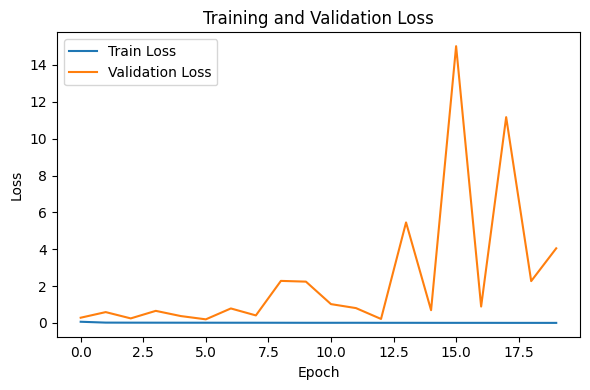

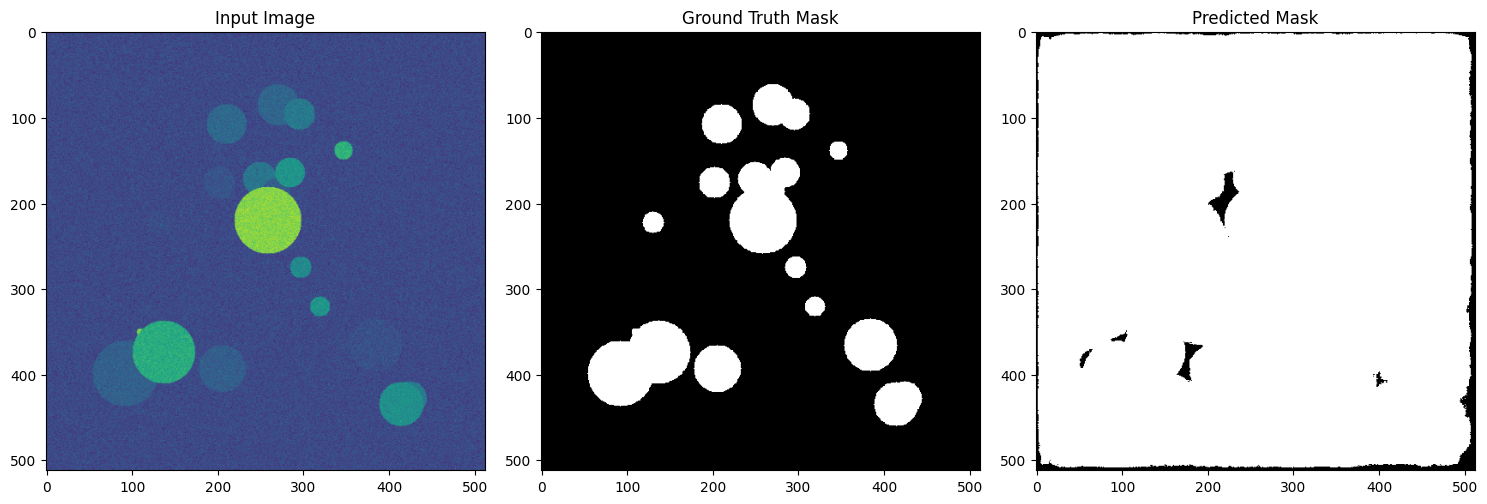


Final Test Results:
Test Loss: 3.7694
Test Accuracy: 0.4374


In [14]:
main(model = UNet(n_channels=3, out_channels=2),
     n_epochs = 20,
     model_name = 'Unet'
     )    

Starting training...
Epoch 1/13:
Train Loss: 0.0548
Train Accuracy: 0.9916
Val Loss: 0.4144
Val Accuracy: 0.8819
Epoch 2/13:
Train Loss: 0.0212
Train Accuracy: 0.9946
Val Loss: 0.5812
Val Accuracy: 0.8725
Epoch 3/13:
Train Loss: 0.0177
Train Accuracy: 0.9954
Val Loss: 0.3581
Val Accuracy: 0.8685
Epoch 4/13:
Train Loss: 0.0166
Train Accuracy: 0.9956
Val Loss: 0.3026
Val Accuracy: 0.8805
Epoch 5/13:
Train Loss: 0.0158
Train Accuracy: 0.9958
Val Loss: 0.3111
Val Accuracy: 0.8673
Epoch 6/13:
Train Loss: 0.0148
Train Accuracy: 0.9959
Val Loss: 0.5145
Val Accuracy: 0.8101
Epoch 7/13:
Train Loss: 0.0144
Train Accuracy: 0.9960
Val Loss: 0.7354
Val Accuracy: 0.8529
Epoch 8/13:
Train Loss: 0.0134
Train Accuracy: 0.9962
Val Loss: 0.2411
Val Accuracy: 0.8951
Epoch 9/13:
Train Loss: 0.0120
Train Accuracy: 0.9966
Val Loss: 0.6945
Val Accuracy: 0.8098
Epoch 10/13:
Train Loss: 0.0112
Train Accuracy: 0.9967
Val Loss: 0.3354
Val Accuracy: 0.8644
Epoch 11/13:
Train Loss: 0.0105
Train Accuracy: 0.9969
Val

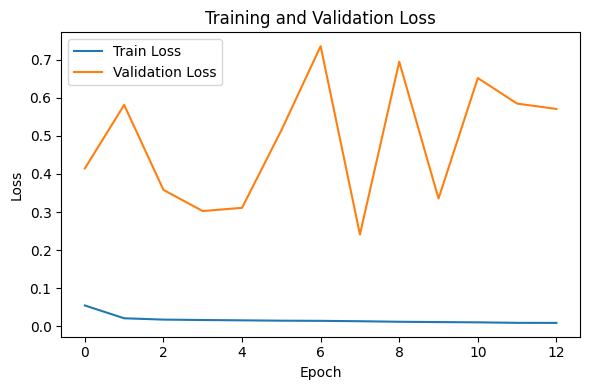

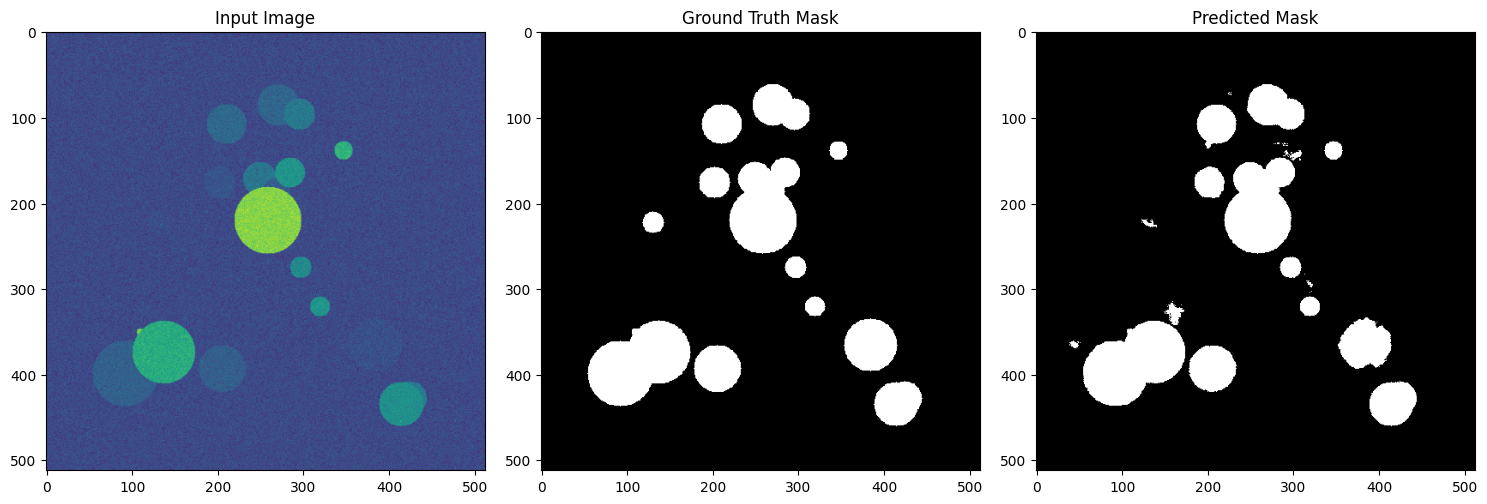


Final Test Results:
Test Loss: 0.5609
Test Accuracy: 0.8696


In [15]:
main(model = UNet(n_channels=3, out_channels=2),
     n_epochs = 13,
     model_name = 'Unet'
     )  

Starting training...
Epoch 1/10:
Train Loss: 0.0848
Train Accuracy: 0.9886
Val Loss: 0.4393
Val Accuracy: 0.8640
Epoch 2/10:
Train Loss: 0.0211
Train Accuracy: 0.9947
Val Loss: 0.6332
Val Accuracy: 0.8367
Epoch 3/10:
Train Loss: 0.0173
Train Accuracy: 0.9955
Val Loss: 0.8335
Val Accuracy: 0.8168
Epoch 4/10:
Train Loss: 0.0166
Train Accuracy: 0.9956
Val Loss: 0.4846
Val Accuracy: 0.8155
Epoch 5/10:
Train Loss: 0.0158
Train Accuracy: 0.9958
Val Loss: 1.1793
Val Accuracy: 0.7151
Epoch 6/10:
Train Loss: 0.0146
Train Accuracy: 0.9961
Val Loss: 0.5171
Val Accuracy: 0.8301
Epoch 7/10:
Train Loss: 0.0140
Train Accuracy: 0.9962
Val Loss: 0.5922
Val Accuracy: 0.8009
Epoch 8/10:
Train Loss: 0.0130
Train Accuracy: 0.9964
Val Loss: 0.6828
Val Accuracy: 0.7862
Epoch 9/10:
Train Loss: 0.0121
Train Accuracy: 0.9966
Val Loss: 1.0844
Val Accuracy: 0.6638
Epoch 10/10:
Train Loss: 0.0112
Train Accuracy: 0.9968
Val Loss: 2.5114
Val Accuracy: 0.5677


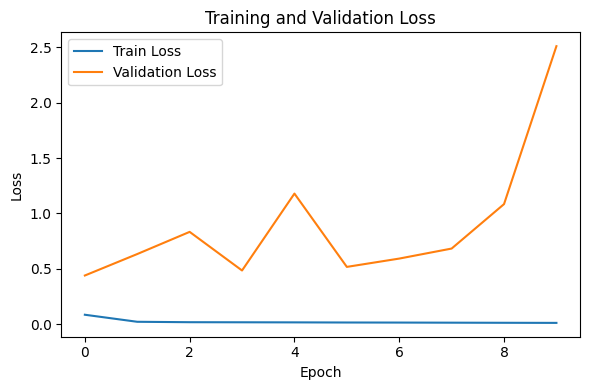

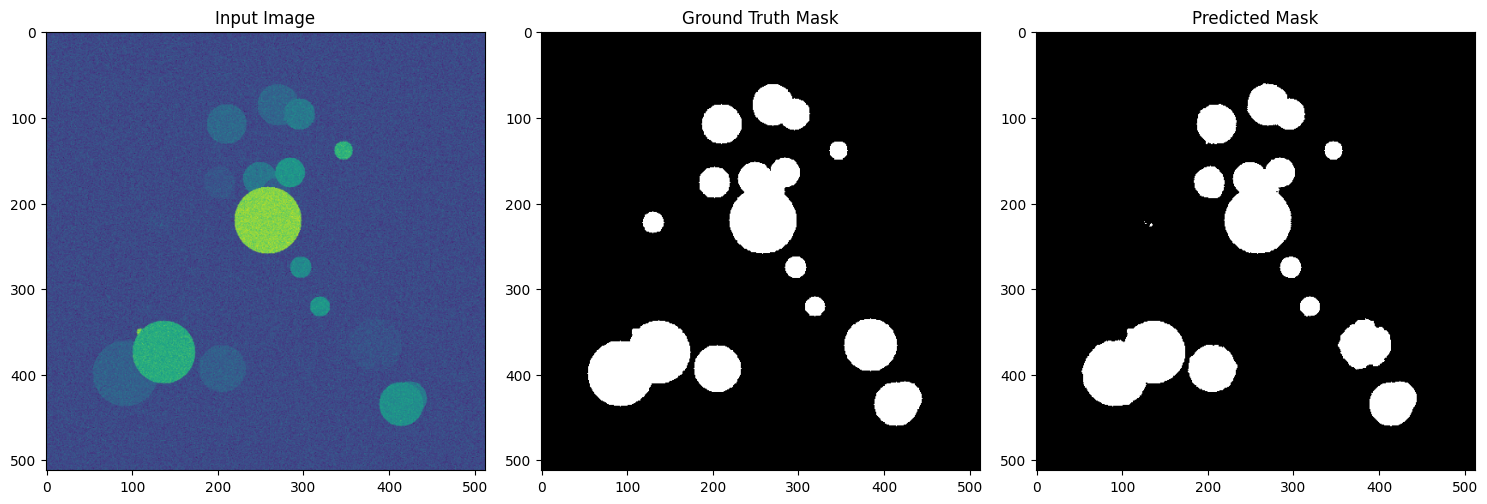


Final Test Results:
Test Loss: 2.6433
Test Accuracy: 0.5412


In [11]:
main(model = UNet(n_channels=3, out_channels=2),
     n_epochs = 10,
     model_name = 'Unet'
     )    

Starting training...
Epoch 1/6:
Train Loss: 0.0537
Train Accuracy: 0.9915
Val Loss: 0.4291
Val Accuracy: 0.8580
Epoch 2/6:
Train Loss: 0.0202
Train Accuracy: 0.9949
Val Loss: 0.4783
Val Accuracy: 0.8614
Epoch 3/6:
Train Loss: 0.0174
Train Accuracy: 0.9955
Val Loss: 0.8089
Val Accuracy: 0.8135
Epoch 4/6:
Train Loss: 0.0162
Train Accuracy: 0.9957
Val Loss: 0.9539
Val Accuracy: 0.7494
Epoch 5/6:
Train Loss: 0.0152
Train Accuracy: 0.9960
Val Loss: 0.4960
Val Accuracy: 0.8510
Epoch 6/6:
Train Loss: 0.0143
Train Accuracy: 0.9962
Val Loss: 0.4275
Val Accuracy: 0.8211


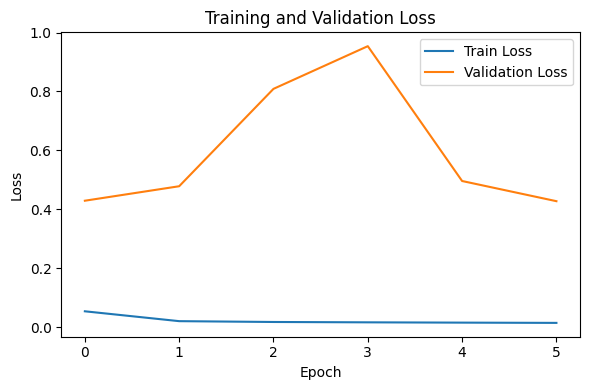

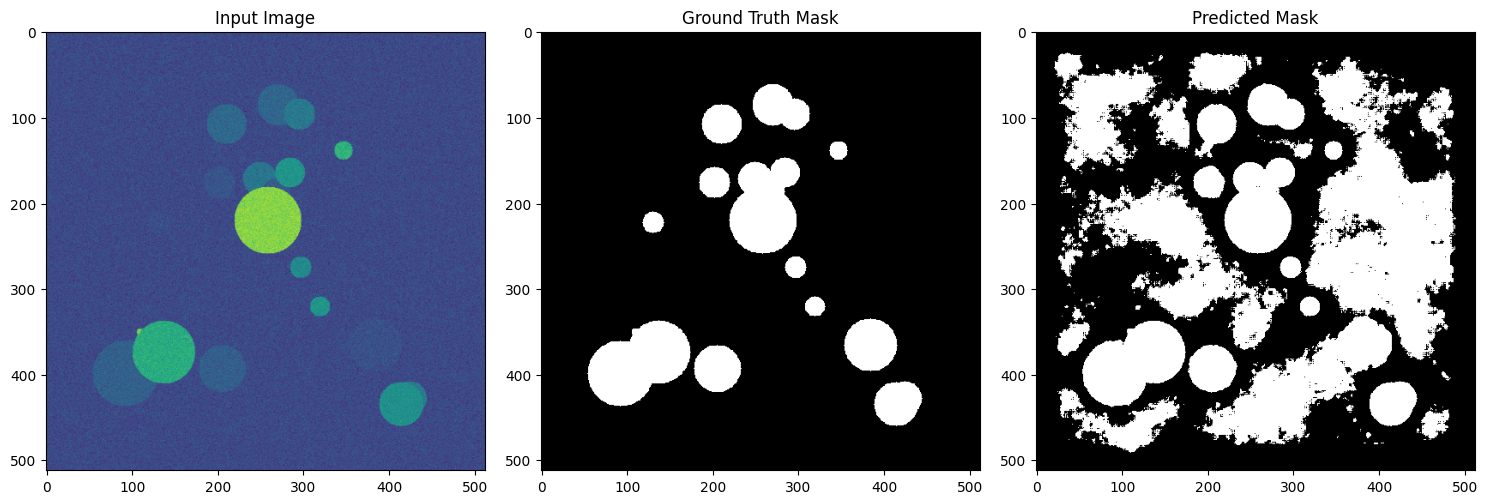


Final Test Results:
Test Loss: 0.4423
Test Accuracy: 0.8280


In [13]:
main(model = UNet(n_channels=3, out_channels=2),
     n_epochs = 6,
     model_name = 'Unet'
     )    

## Лучше всего показала себя модель просле 10 эпох